In [1]:
import numpy as np
import pyshtools as sh
import matplotlib.pyplot as plt

import spherical_inr as sph
import spherical_inr.differentiation as D
import torch

import scripts
from scripts._units import *

In [2]:
partials_func = scripts.acc_cnm_partials # function to use for partials computation
rng = np.random.default_rng()

In [3]:
L_gt = 120 # macimum degree of the coefficients used to simulate the measurements
L_est = 100 # maximum degree of the coefficients to be estimated

# Read SH coefficients, and cut to L_gt
file_name = "spice/data/jgmro_120d_sha.tab"
coeffs, r_0, gm = scripts.read_SHADR(file_name)
cnm_gt = coeffs[:, : L_gt + 1, : L_gt + 1]

# Index array and dictionary to go from a matrix of Cnm to a 1D array, and vice-versa
cnm_idx_sim, cnm_map_sim = scripts.get_cnm_idx(L_gt)
cnm_idx_est, cnm_map_est = scripts.get_cnm_idx(L_est)

### Training & Testing Data

In [4]:
xyz_coords_train, sph_coords_train = scripts.points_from_grid(L_est, r=(r_0 + 234.0 * km)) 

pot_train, acc_train = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_train)
]

100%|██████████| 121/121 [00:24<00:00,  5.03it/s]


In [5]:
xyz_coords_test, sph_coords_test = scripts.points_from_grid(L_gt, r=(r_0 * 1.1), use_GLQ_grid=True)

pot_test, acc_test = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_test)
]

100%|██████████| 121/121 [00:32<00:00,  3.67it/s]


## Least Square

### Set Up & Solving Normal Equation

In [6]:
dim = 3 # dimension of the measurements
N_coords = xyz_coords_train.shape[0]

cnm_est_mat = np.empty((2, L_est + 1, L_est + 1), dtype=bool)
noise = 1e-4 * gm / np.pow(r_0, 2)

In [7]:
N_mat, y, _ = scripts.compute_normal_equations(
    cnm_mat = cnm_est_mat,
    sph_coords = sph_coords_train,
    partials_func=partials_func,
    r_0 = r_0,
    batch_size=1000,
    msr_noise = noise,
    partials_scale=gm,
    raw_msr_vec=acc_train.reshape(N_coords * dim),
    perturb_msr=False   
)

100%|██████████| 21/21 [03:38<00:00, 10.40s/it]


In [8]:
cnm_est, _ = scripts.solve_normal_equations(
    N_mat= N_mat, 
    y = y, 
    compute_covariance=False
)

cnm_est_mat = cnm_est_mat.astype(np.double)
cnm_est_mat[*cnm_idx_est.T] = cnm_est

Solving via lstsq...
Took 518.08 s


In [9]:
del N_mat, y

### Prediction

In [10]:
pot_pred, acc_pred = [
    el * gm for el in scripts.compute_pot_acc(cnm_est_mat, r_0, sph_coords_test)
]

100%|██████████| 101/101 [00:22<00:00,  4.52it/s]


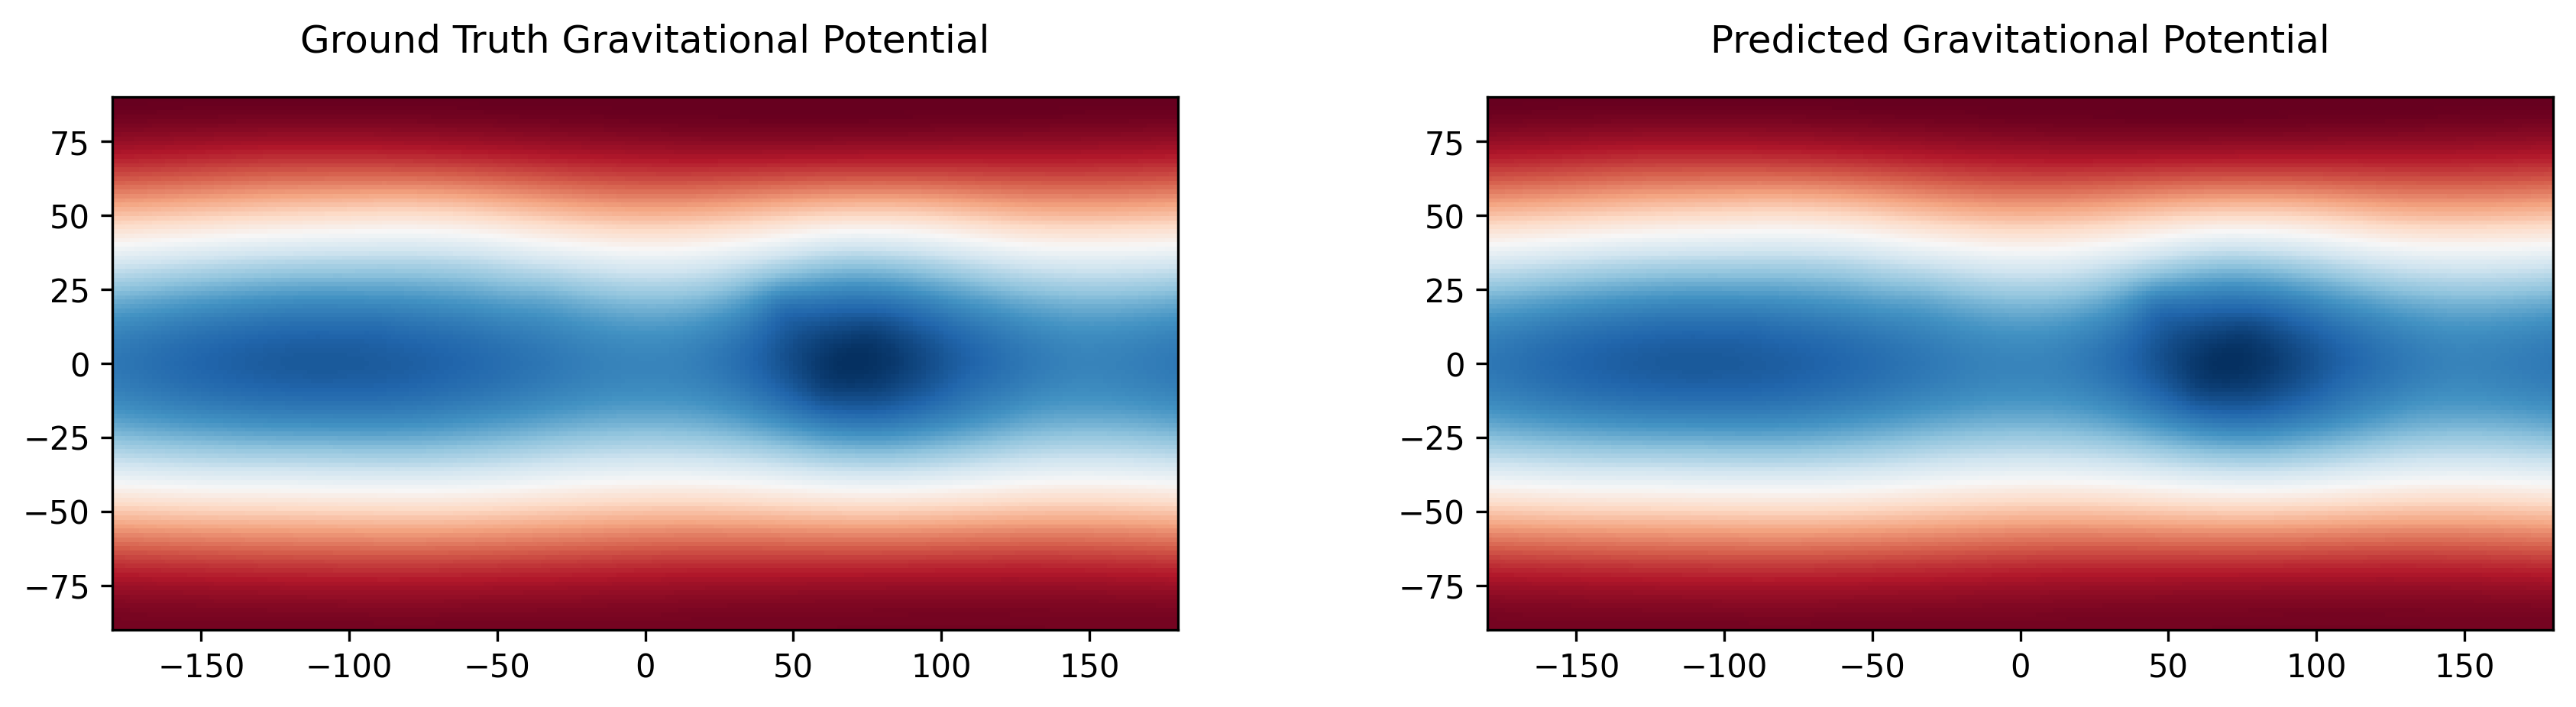

In [11]:
data_test = pot_test.reshape(L_gt+1, 2*(L_gt+1) - 1)
data_pred = pot_pred.reshape(L_gt+1, 2*(L_gt+1) - 1)


fig = plt.figure(figsize=(12, 12), dpi = 300)
subfigs = fig.subfigures(1, 2)

scripts.plot_sphere(data_test,   fig= subfigs[0], cmap = "RdBu", title="Ground Truth Gravitational Potential")
scripts.plot_sphere(data_pred,   fig= subfigs[1], cmap = "RdBu", title="Predicted Gravitational Potential")
plt.show()

### Error

In [12]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 0.00047907 - Median: 0.00042897 -  RMS: 0.00058362 - SNR (dB):10.228


## HNET

### Data Preprocessing

We define some reference value for the radius, potential and acceleration to later un-dimensionalize them. 

In [13]:
r_star =(r_0 + 234.0 * km)
u_star = gm / r_star
a_star = u_star / r_star

print(
    f"u_star = {u_star} [m^2/s^2]",
    f"r_star = {r_star} [m]",
    f"a_star = {a_star} [m/s^2]",
    sep="\n"
)

u_star = 11798450.63794934 [m^2/s^2]
r_star = 3630000.0 [m]
a_star = 3.2502618837326005 [m/s^2]


Deep Learning model needs to work with scaled data

In [14]:
pot_train_scaled = pot_train.copy().reshape(-1, 1) / u_star
acc_train_scaled = acc_train.copy() / a_star

pot_test_scaled = pot_test.copy().reshape(-1, 1) / u_star
acc_test_scaled = acc_test.copy() / a_star

sph_coords_train_scaled = sph_coords_train.copy()
sph_coords_train_scaled[:, 0] /= r_star

sph_coords_test_scaled = sph_coords_test.copy()
sph_coords_test_scaled[:, 0] /= r_star

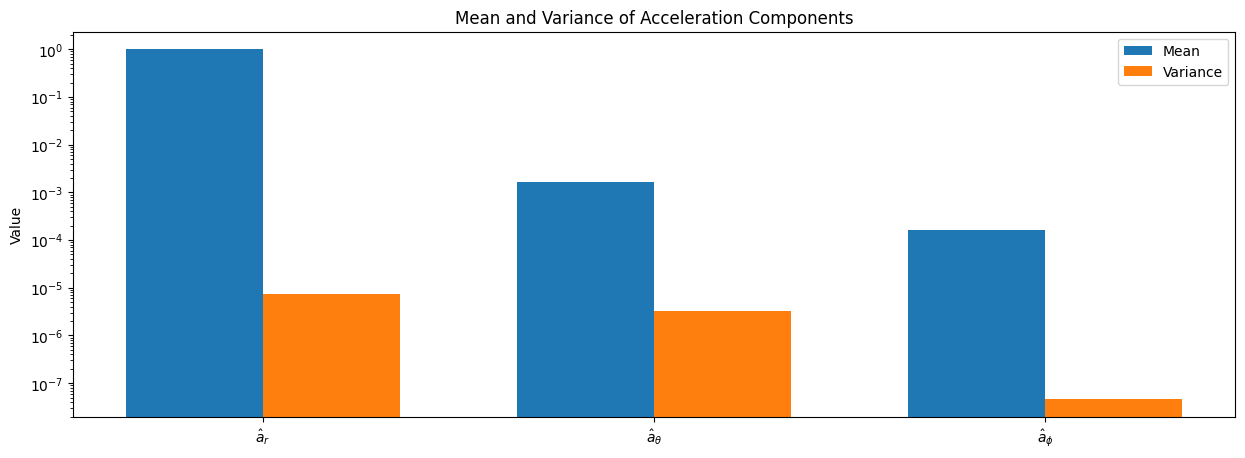

In [15]:
# Compute mean and variance for each component of the acceleration (spherical frame)
mean_vals = np.mean(np.abs(acc_train_scaled), axis=0)
var_vals = np.var(acc_train_scaled, axis=0)
labels_acc = [r'$\hat{a}_{r}$', r'$\hat{a}_{\theta}$', r'$\hat{a}_{\phi}$']

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))


x = np.arange(len(labels_acc))
width = 0.35  # width of the bars

ax1.bar(x - width/2, mean_vals, width, label='Mean')
ax1.bar(x + width/2, var_vals, width, label='Variance')
ax1.set_ylabel('Value')
ax1.set_title('Mean and Variance of Acceleration Components')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_acc)
ax1.legend()
ax1.set_yscale('log')

plt.show()

In [16]:
xtrain = torch.tensor(sph_coords_train_scaled.copy(), dtype=torch.float32).requires_grad_(True)
ytrain = torch.tensor(acc_train_scaled.copy(), dtype=torch.float32)

xtest = torch.tensor(sph_coords_test_scaled.copy(), dtype=torch.float32)
ytest = torch.tensor(pot_test_scaled.copy(), dtype=torch.float32)

In [17]:
def gen_random_s2(n : int):
    v = torch.randn(n, 3)
    v /= torch.norm(v, dim=1).reshape(-1, 1)
    r = torch.tensor(10.0*np.random.uniform(.1, 1, n)**(1/3), dtype=torch.float32)
    
    
    theta = torch.acos(v[:, 2])
    phi = torch.atan2(v[:, 1], v[:, 0])
    v = torch.stack((r, theta, phi), dim=1)
    return v

### Model

In [18]:
class ModifiedHHNET(sph.INR):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x= sph.transforms.rsph2_to_cart3(x)
        x = super().forward(x)
        return x
        

hnet= ModifiedHHNET(
    input_dim=3,
    output_dim = 1, 
    inr_sizes = [100] + 4*[100],
    pe = "irregular_herglotz",
    activation = "mish",
    bias= False,  
)

### Loss

In [19]:
def loss_modified(target, output, input, alpha_t = 1e3, alpha_p = 1e4):
    
    ddr, ddt, ddp = D.spherical_gradient(output, input, track=True).unbind(-1)
    target_r, target_t, target_p = target.unbind(-1)
    scale = target_r.abs()
    loss = torch.nn.functional.mse_loss(ddr/scale, target_r) + alpha_t * torch.nn.functional.mse_loss(ddt, target_t) + alpha_p*torch.nn.functional.mse_loss(ddp, target_p)

    return loss

In [20]:
Reg = sph.SphericalLaplacianLoss()
MSE = torch.nn.MSELoss()

def loss_fn(target, output, input, yreg, xreg):
    return loss_modified(target, output, input) +  1e1*Reg(yreg, xreg)
    

### Training

In [21]:
epoch = 1000
batch_size = 4096
lr = 1e-3
optimizer = torch.optim.Adam(hnet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

In [22]:
dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader =torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

hnet.train()
for ep in range(epoch):
    epoch_loss = 0.0
    xreg = gen_random_s2(100).requires_grad_(True)
    for xb, yb in dataloader:
        optimizer.zero_grad()
        ypred = hnet(xb)
        yreg = hnet(xreg)
        loss = loss_fn(yb, ypred, xb, yreg, xreg)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    hnet.eval()
    with torch.no_grad():
        ytest_pred = hnet(xtest)
        val_loss = MSE(ytest_pred, ytest) ** 0.5
    hnet.train()
    
    if ep % 5 == 0:
        print(f"Epoch {ep} Loss {epoch_loss**0.5} Val Loss {val_loss.item()}")

Epoch 0 Loss 0.9033526572545384 Val Loss 0.6865816712379456
Epoch 5 Loss 0.15270416834248512 Val Loss 0.13279122114181519
Epoch 10 Loss 0.037639698451044847 Val Loss 0.08526978641748428
Epoch 15 Loss 0.021380354884874154 Val Loss 0.10471011698246002
Epoch 20 Loss 0.017880169330659577 Val Loss 0.10225815325975418
Epoch 25 Loss 0.016660150760502153 Val Loss 0.10237898677587509
Epoch 30 Loss 0.01586861554524231 Val Loss 0.10228727757930756
Epoch 35 Loss 0.03897469681018149 Val Loss 0.10264614224433899
Epoch 40 Loss 0.014638481134122496 Val Loss 0.10089030861854553
Epoch 45 Loss 0.015398989883138474 Val Loss 0.10131416469812393
Epoch 50 Loss 0.04063045013530438 Val Loss 0.10152764618396759
Epoch 55 Loss 0.016473858541463687 Val Loss 0.09992045909166336
Epoch 60 Loss 0.014214218460297535 Val Loss 0.09955699741840363
Epoch 65 Loss 0.012088110181092269 Val Loss 0.09960609674453735
Epoch 70 Loss 0.011868359307288905 Val Loss 0.09961280971765518
Epoch 75 Loss 0.011828561709894875 Val Loss 0.099

In [23]:
def U(x):
    return u_star * (hnet(x).squeeze().detach().numpy())

### Errors

In [24]:
hnet.eval()
pot_pred = U(xtest)

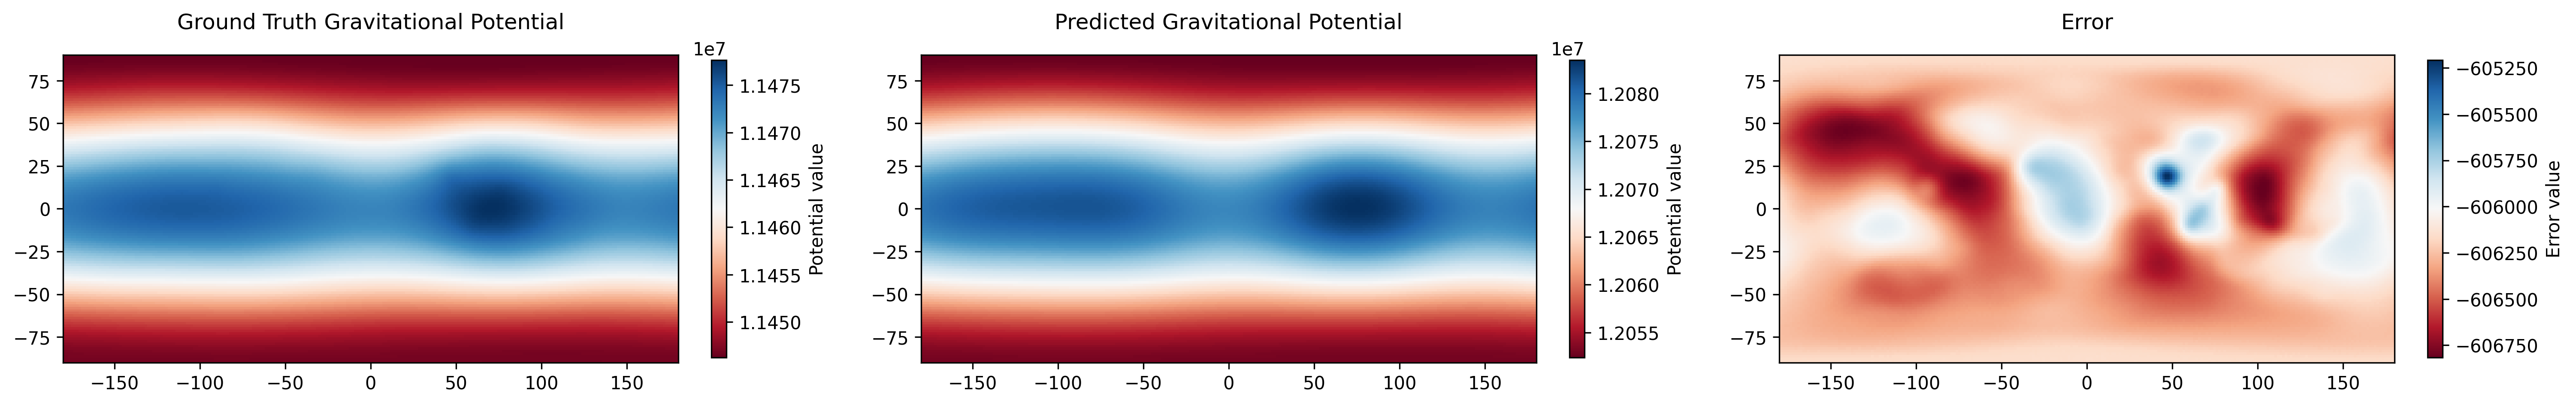

In [25]:
# coeffs = sh.SHCoeffs.from_array(cnm_gt)
data_pred = pot_pred.reshape(  (L_gt+1, 2*(L_gt+1) - 1))
data_test = pot_test.reshape( (L_gt+1, 2*(L_gt+1) - 1))

fig = plt.figure(figsize=(20, 15), dpi = 300)
subfigs = fig.subfigures(1, 3)
scripts.plot_sphere(data_test,   fig= subfigs[0], cmap = "RdBu", title="Ground Truth Gravitational Potential")
ax = subfigs[0].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

scripts.plot_sphere(data_pred,   fig= subfigs[1], cmap = "RdBu", title="Predicted Gravitational Potential")
ax = subfigs[1].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

scripts.plot_sphere(data_test - data_pred,   fig= subfigs[2], cmap = "RdBu", title="Error")
ax = subfigs[2].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Error value')

plt.show()

In [26]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: -6.0627e+05 - Median: -6.0625e+05 -  RMS: 6.0627e+05 - SNR (dB):1.2765
